<a href="https://colab.research.google.com/github/wonyoung-ji/study/blob/master/Hands-On%20Machine%20Learning/2%EC%9E%A5_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%B2%98%EC%9D%8C%EB%B6%80%ED%84%B0_%EB%81%9D%EA%B9%8C%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
      
# 불필요한 경고를 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# __2.3 데이터 가져오기__

## __2.3.2 데이터 다운로드__

In [2]:
import os
import tarfile
import urllib.request
import warnings
warnings.filterwarnings(action='ignore')

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path = os.path.join(housing_path, 'housing_tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

## __2.3.3 데이터 구조 훑어보기__

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- 총 20,640개의 샘플 존재
- total_bedrooms는 207개의 null값이 존재
- ocean_proximity만 빼고 모든 column은 숫자형


In [7]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

- ocean_proximity는 INLAND, NEAR OCEAN, NEAR BAY, ISLAND 총 4개의 범주형 변수

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


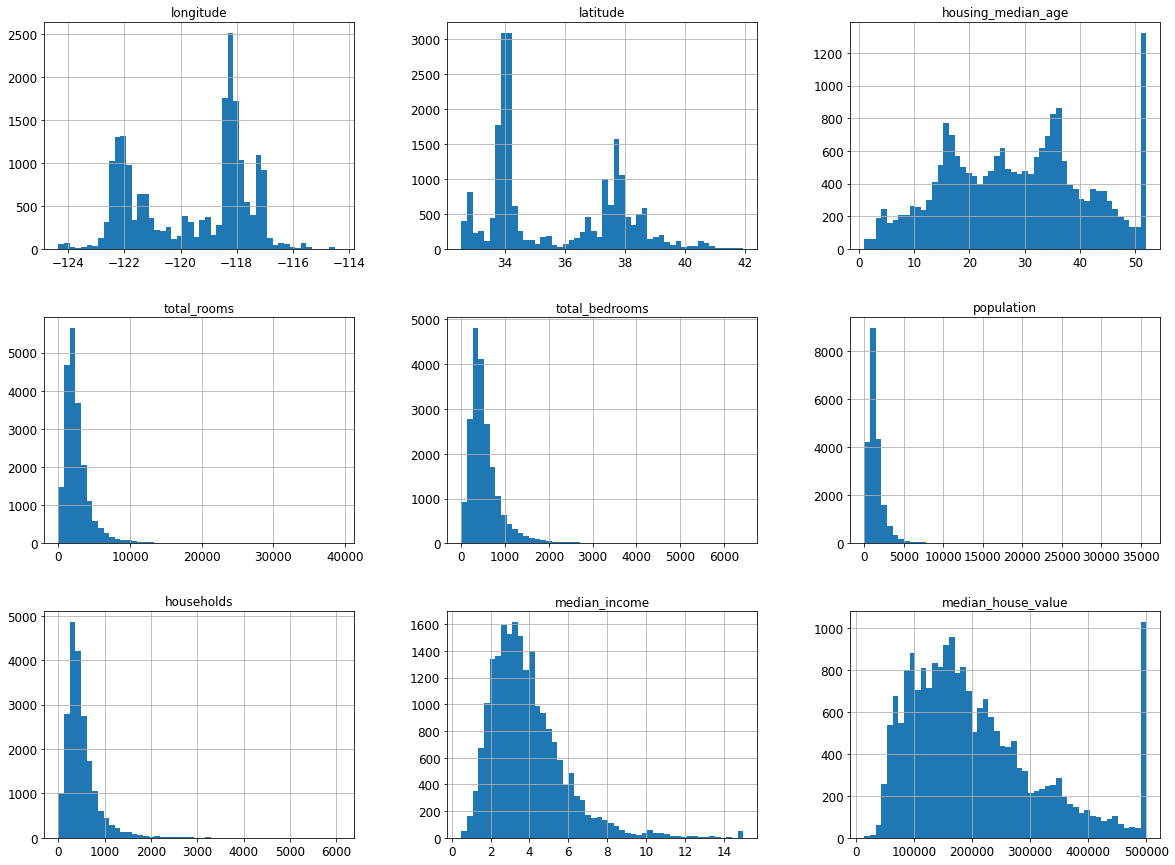

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

- median_income은 US 달러로 표시되어 있지 않음. 실제로 3은 약 30,000달러를 의미
- housing_median_age와 median_house_value는 최댓값과 최솟값이 정해져 있음. 그래프의 맨 오른쪽 값이 솟은 것으로 보아, 마지막 값으로 한정되었음을 짐작 가능
- 특히, median_house_value는 레이블로 사용이 되기 때문에, 검토가 필요
  + 한곗값 밖의 구역에 대한 정확한 레이블을 구한다
  + 훈련 세트에서 $500,000을 넘는 구역을 제거
- 많은 히스토그램이 왼쪽보다 오른쪽으로 멀리 뻗쳐있음. 이 특성들을 좀 더 종 모양의 분포가 되도록 변형 필요

## __2.3.4 테스트 세트 만들기__

In [10]:
# 여러번 런타임을 돌려도 같은 값이 나오도록
np.random.seed(42)

- 만약 초깃값이 없다면 런타임을 99999번 돌렸을 때, 모든 데이터셋을 보게 되는 것이므로, 초깃값을 지정한다.

In [11]:
import numpy as np
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
print('length of train set:', len(train_set))
print('length of test set:', len(test_set))

length of train set: 16512
length of test set: 4128


- __더욱 완벽한 테스트 세트 만들기__

- 만약, 데이터셋이 업데이트가 된다면, 새로운 테스트셋에 이전 훈련데이터가 포함되지 않게 해야 한다.
- 이를 해결하기 위해, 식별자를 사용한다.
  + 즉, 데이터셋을 업데잍 한 후에도, 샘플의 식별자를 사용하여 테스트 세트로 보낼지 말지 정하는 것
  + 예를들어, 각 샘플마다 식별자의 해시값을 계산하여 해시 최댓값의 20%보다 작거나 같은 샘플만 테스트 세트로 보냄 

In [13]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32    # 0xffffffff 16진수

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

- 주택 데이터셋에는 식별자 컬럼이 없으므로, 대신 행의 인덱스를 ID로 사용

In [14]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

- 위도와 경도를 활용하여 새로운 id 생성

In [15]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [16]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


- 사실은, 사이킷런에 train_test_split() 이라고 테스트셋과 트레인셋을 나누는 방법이 있음
  + random_state 매개변수로 난수 초깃값을 지정할 수도 있음
  + 행의 개수가 같은 여러 개의 데이터셋을 넘겨서 같은 인덱스를 기반으로 나눌 수 있음(데이터프레임이 레이블에 따라 여러 개로 나뉘어 있을 때 매우 유용)

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

- 그러나, __계층적 샘플링__을 지키지 못한 상태
- 이를 위하여, 중간소득별 계층을 나누어 랜덤추출 필요

- 중간소득별 카테고리 생성

In [18]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1,2,3,4,5])

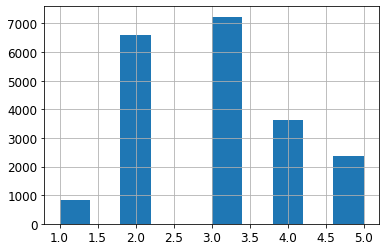

In [19]:
housing['income_cat'].hist()

- 소득 기반으로 계층 샘플링

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [21]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [22]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

# __2.4 데이터 이해를 위한 탐색과 시각화__


In [23]:
housing = strat_train_set.copy()

## __2.4.1 지리적 데이터 시각화__

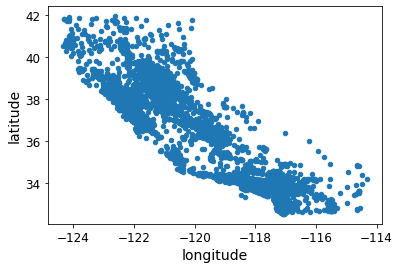

In [24]:
housing.plot(kind='scatter', x='longitude', y='latitude')

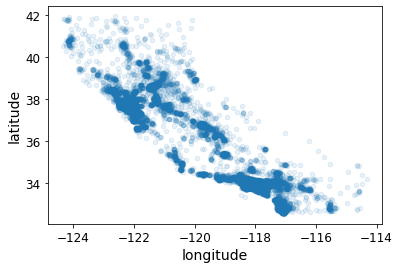

In [25]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

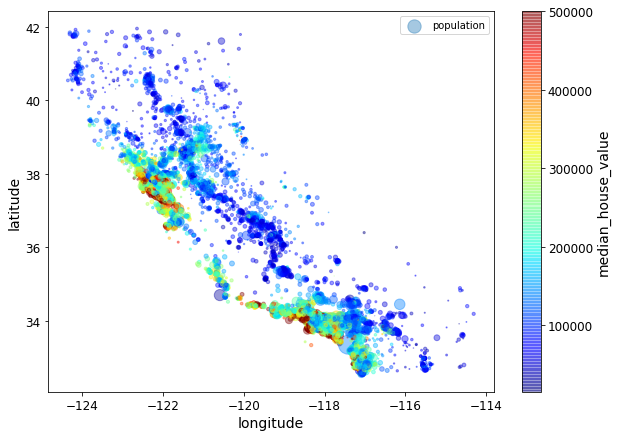

In [26]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

- s: 원의 크기. 인구를 나타냄
- c: 색상. 가격 (파란색 ~ 빨간색)

- 주택 가격은 지역(바다와 밀접)과 인구 밀도에 관련이 큼
- 군집 알고리즘을 이용하여 주요 군집을 찾고, 군집 중심까지의 거리를 재는 특성 추가 가능

## __2.4.2 상관관계 조사__
- 표준 상관계수(피어슨 상관계수) 사용

In [27]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

- 중간주택가격(median_house_value)은 중간소득(median_income)이 증가할 때 올라가는 경향있음
- 위도(latitude)와 중간주택가격은 약한 음의 상관관계. 즉, 북쪽으로 갈 수록 주택 가격이 내려가는 경향

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a72c8eb38>,
      dtype=object)

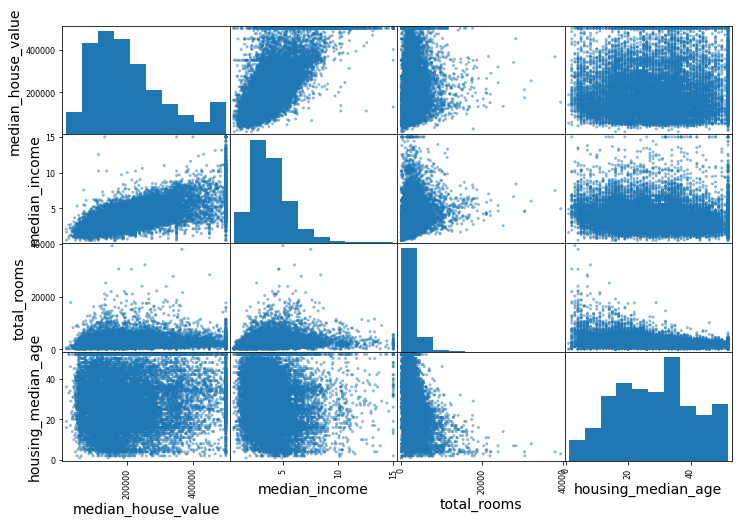

In [28]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

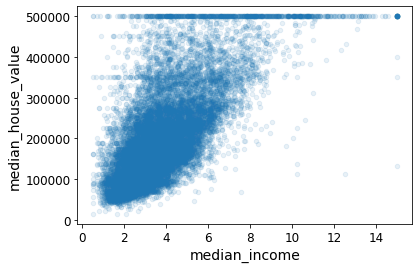

In [29]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

- 상관관계 매우 강함
- 제한값 $500,000에 수평선이 나타남
- 450,000 근처에 수평선 보임. 350,000와 280,000에도 존재.
  + __이런 이상한 형태를 학습하지 않도록 해당 구역 제거 필요__

## __2.4.3 특성 조합으로 실험__
- 정제 필요한 이상 데이터 발견함
  + ex.꼬리가 두꺼운 분포의 데이터 > 로그 스케일 사용
- 흥미로운 특성 조합?
  + 가구당 방 개수
  + 가구당 인원
- 프로토타입을 만들고 실행하여, 분석 및 통찰을 얻음. 그 후 다시 이 단계로 돌아옴

In [30]:
housing['rooms_per_houshold'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [31]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_houshold          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

- bedrooms_per_room: 전체 방 개수나 침실개수 보다 중간주택가격과의 상관관계가 훨씬 높게 나옴. 즉, 침실/방의 비율이 낮을수록 더 비싼 경향이 있음.
- rooms_per_household: 전체 방 개수보다 더 유용. 큰 집이 더 비쌈.

# __2.5 머신러닝 알고리즘을 위한 데이터 준비__
- 함수를 만들어 데이터를 준비하는 이유


1.   어떤 데이터셋이라도 데이터 변환 쉽게 가능 (다음번 새로운 데이터셋을 사용할 때)
2.   향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축 가능
3.   실제 시스템에서 알고리즘에 새 데에이터를 주입하기 전, 변환시키는 데 사용가능
4.    어떤 조합이 가장 좋은지 확인에 편리






In [32]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

## __2.5.1 데이터 정제__
- null 값 처리
  + 해당 구역 제거
  + 전체 특성 삭제
  + 어떠한 값으로 채우기 (0, 평균, 중앙값 등)

In [33]:
# housing.dropna(subset=['total_bedrooms])    # 1번
# housing.drop('total_bedrooms', axis=1)      # 2번
# median = housing['total_bedrooms].median()  # 3번
# housing['total_bedrooms'].fillna(median, inplace=True)

In [34]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [35]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [36]:
imputer.fit(housing_num)    # 학습
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

- imputer는 결과를 statistics_에 저장

In [37]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [38]:
X = imputer.transform(housing_num)  # 학습한 중간값으로 null값 대체

- 나오는 결과는 넘파이 배열 형태. 판다스 데이터프레임으로 변환 가능

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


## __2.5.2 텍스트와 범주형 특성 다루기__

In [40]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [41]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7276
INLAND             5263
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

- 범주형 데이터이므로, 카테고리들을 텍스트 > 숫자 변환 필요

In [42]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.]])

In [43]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- 그러나 OrdinalEncoder는 카테고리 순서별로 붙어있는 것들을 비슷하다고 인식함
  + bad, average, good, excellent와 같은 경우는 상관이 없지만,
  + '<1H OCEAN', 'INLAND', 'NEAR OCEAN'만 봐도, 0과 1보단 0과 2가 더 가까워 보임
- 이를 보완하기 위해 원핫인코딩 사용

In [44]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

- 출력된 값은 넘파이가 아닌 희소행렬 값
- 희소행렬은 카테고리가 수천 개일 경우 매우 효율적: 원소의 위치만 저장
- 희소행렬을 넘파이 행렬로 바꾸려면 toarray() 사용

In [45]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [46]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

- 카테고리수가 많을 경우, 범주형 입력값을 숫자형 특성으로 바꿀 수 있음 >> 임베딩
- 임베딩: 학습 가능한 저차원 벡터로 변환

## __2.5.3 나만의 변환기__

- TransformerMixin 상속시 fit_transform() 생성 가능
- BaseEstimator 상속시 get_params(), set_params() 생성 가능(하이퍼파라미터 튜닝에 사용됨)

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedroom_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housingn_extra_attribs = attr_adder.transform(housing.values)

## __2.5.4 특성 스케일링__

- 입력된 데이터들의 스케일이 어느정도 비슷해야 함
  + 전체 방 개수의 범위는 6 ~ 39,320
  + 중간 소득의 범위: 0 ~ 15
- 타킷에 대한 스케일링은 일반적으로 불필요
- 모든 특성의 범위를 같도록 만드는 방법: __min-max 스케일링(정규화), 표준화__

## __2.5.5 변환 파이프라인__